In [65]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path
data_dir = Path("../data")

In [28]:
fb_df = pd.read_csv(data_dir / "fb-pages-food.edges", names=["node_1", "node_2"])
fb_df = fb_df.sort_values(by=["node_1", "node_2"])
print("Shape:", fb_df.shape)
fb_df.head()

Shape: (2102, 2)


,node_1,node_2
1,0,58
2,0,132
0,0,276
4,0,398
5,0,555


In [41]:
# Remuevo self-loops (probablemente sean errores en los datos)
fb_df = fb_df[(fb_df["node_1"] != fb_df["node_2"])]

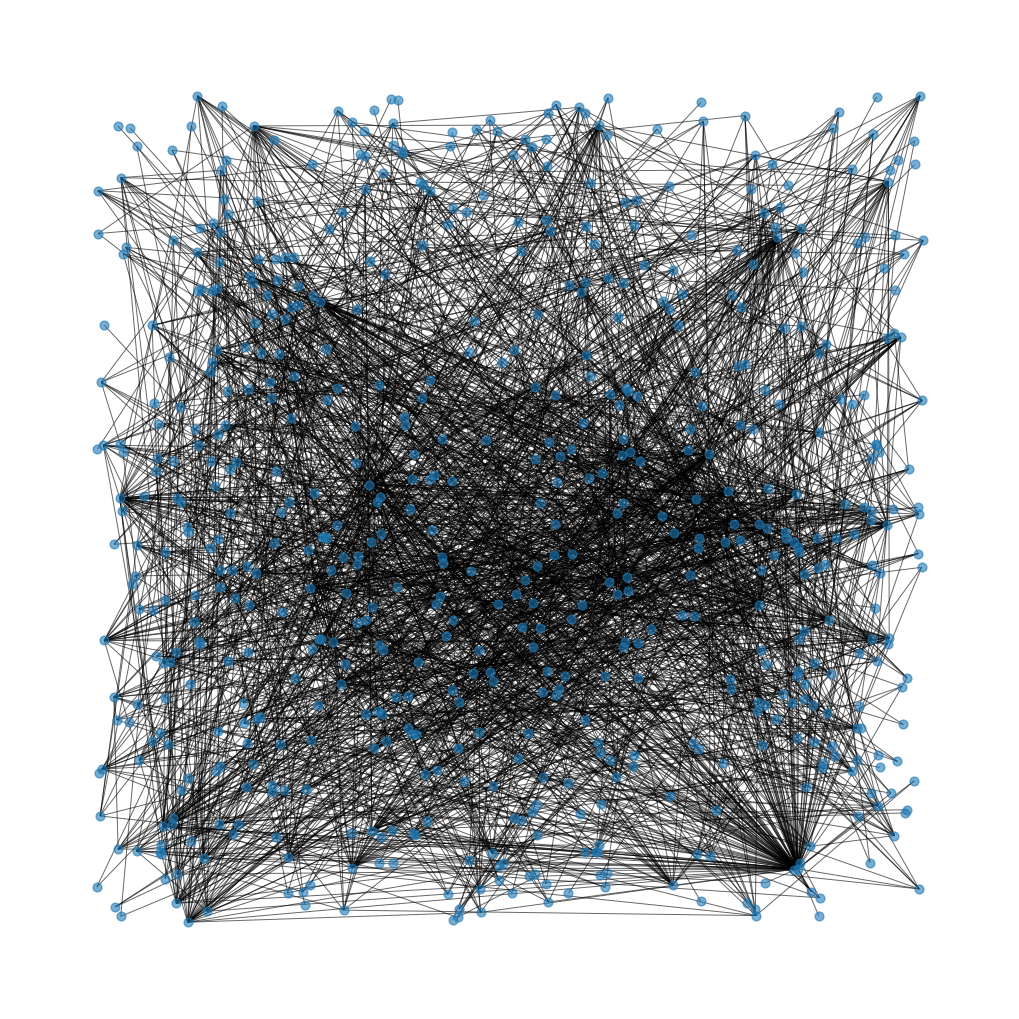

In [42]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [43]:
# combine all nodes in a list
node_list = [v for v in G.nodes()]

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [44]:
adj_G.shape

(620, 620)

In [45]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(i+1, adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:09<00:00, 67.89it/s] 


In [46]:
len(all_unconnected_pairs)

19015

In [47]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [48]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2091/2091 [00:09<00:00, 210.40it/s]


In [49]:
len(omissible_links_index)

1472

In [70]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = pd.concat([data, fb_df_ghost], ignore_index=True)
data = data.set_index(["node_1", "node_2"])

In [71]:
data['link'].value_counts()

0    19015
1     4416
Name: link, dtype: int64

In [72]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [73]:
data

link
node_1 node_2      
0      228        0
       6          0
       478        0
       288        0
       289        0
...             ...
576    584        1
       601        1
584    603        1
597    601        1
601    603        1

[23431 rows x 1 columns]

In [74]:
algorithms = {
    "resource": nx.resource_allocation_index,
    "jaccard": nx.jaccard_coefficient,
    "adamic_adar": nx.adamic_adar_index,
}

metrics = data.copy()
for algo_name, algorithm in algorithms.items():
    metric = pd.DataFrame(
        list(algorithm(G_data)),
        columns=["source", "target", algo_name]
    ).set_index(keys=["source", "target"])
    metrics[algo_name] = metric
    #metrics.join(metric, )
metrics = metrics.fillna(0)
metrics.head()

link  resource  jaccard  adamic_adar
node_1 node_2                                      
0      228        0       0.0      0.0          0.0
       6          0       0.0      0.0          0.0
       478        0       0.0      0.0          0.0
       288        0       0.0      0.0          0.0
       289        0       0.0      0.0          0.0

In [92]:
metrics.groupby(by="link").mean()

,resource,jaccard,adamic_adar
link,,,
0,0.000727,0.002872,0.002748
1,0.012971,0.027228,0.043784


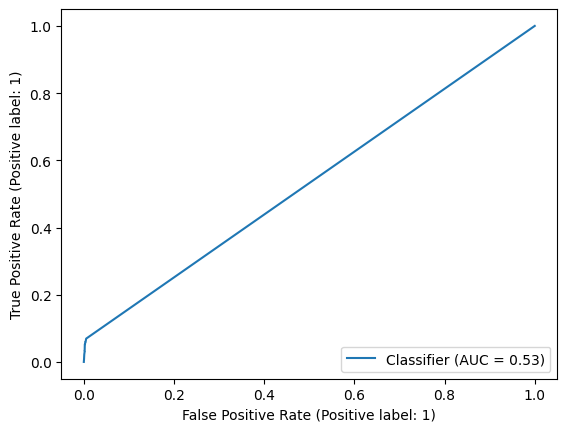

In [93]:
RocCurveDisplay.from_predictions(metrics["link"], metrics["resource"]);

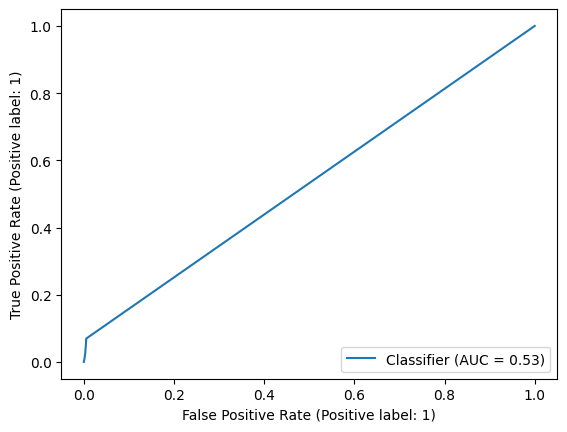

In [94]:
RocCurveDisplay.from_predictions(metrics["link"], metrics["jaccard"]);

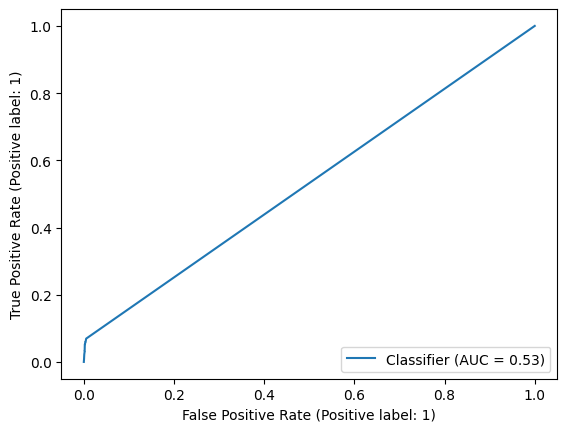

In [95]:
RocCurveDisplay.from_predictions(metrics["link"], metrics["adamic_adar"]);

In [111]:
#x = metrics.drop(columns=["link"]).values
#x

# Extracción de features mediante node embeddings

In [75]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:02<00:00, 22.97it/s]


In [91]:
x = np.array([
    n2w_model.wv[str(i)] + n2w_model.wv[str(j)]
    for i,j in zip(data.index.get_level_values(0), data.index.get_level_values(1))
])

In [100]:
xtrain, xtest, ytrain, ytest = train_test_split(x, data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [101]:
lr = LogisticRegression(class_weight="balanced", max_iter=1000)

lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [102]:
predictions = lr.predict_proba(xtest)

In [103]:
roc_auc_score(ytest, predictions[:,1])

0.533480366847826

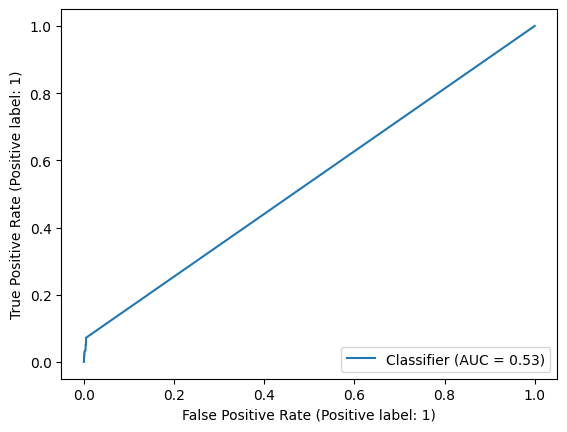

In [104]:
RocCurveDisplay.from_predictions(ytest, predictions[:,1]);

In [105]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[LightGBM] [Info] Number of positive: 3136, number of negative: 13265
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 16401, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191208 -> initscore=-1.442181
[LightGBM] [Info] Start training from score -1.442181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.533567
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.533564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.533569
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/home/nahuel/anaconda3/envs/graphML/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
